# Stage 3: Calculate Metrics and Analyze Results

This notebook:
1. Loads ground truth data and fetched results
2. Calculates accuracy metrics (F1, Precision, Recall) for keys, non-keys, and overall
3. Analyzes performance by strategy
4. Visualizes trade-offs between accuracy, efficiency, and quality
5. Examines performance across different table characteristics

## Setup and Imports

In [49]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 7)

In [50]:
# Configuration
ROOT = Path('.')
PROCESSING_ROOT = ROOT / 'processing'
BENCHMARK_ROOT = ROOT / 'benchmark_tables'
DATA_DIR = PROCESSING_ROOT / '0_data'
FETCHING_DIR = PROCESSING_ROOT / '2_fetching'
OUTPUT_DIR = PROCESSING_ROOT / '3_metrics'

# Find latest directories
data_subdirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()], reverse=True)
fetching_subdirs = sorted([d for d in FETCHING_DIR.iterdir() if d.is_dir()], reverse=True)

if not data_subdirs:
    raise FileNotFoundError(f"No data found in {DATA_DIR}")
if not fetching_subdirs:
    raise FileNotFoundError(f"No fetching results found in {FETCHING_DIR}")

LATEST_DATA_DIR = data_subdirs[0]
LATEST_FETCHING_DIR = fetching_subdirs[0]

print(f'Data directory: {LATEST_DATA_DIR}')
print(f'Fetching directory: {LATEST_FETCHING_DIR}')

# Create output directory
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = OUTPUT_DIR / timestamp
output_dir.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {output_dir}')

Data directory: processing/0_data/20251004_213355
Fetching directory: processing/2_fetching/20251004_224145
Output directory: processing/3_metrics/20251004_231045


## Accuracy Evaluation Functions

These functions are adapted from `X101_Calculate_Metrics.ipynb` to evaluate table accuracy.

In [ ]:
def normalize_value(value, is_date=False):
    """Normalize a cell value for comparison."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return pd.to_datetime(value)
        except:
            pass
        
    if type(value).__module__ == 'numpy':
        value = value.item()

    if isinstance(value, str):
        # Handle numeric strings
        if value.startswith('-') and value.replace('-', '').replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.startswith('=') and value[1:].isdigit():
            return int(value.replace('=', ''))
        if value.startswith('-') and value.replace('-', '').replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        if value.replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'
        
        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return value


def normalize_key(value, is_date=False):
    """Normalize a key column value for matching."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return str(pd.to_datetime(value))
        except:
            pass

    if isinstance(value, str):
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-', '--', 'unknown'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'

        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return str(value)


def normalize_primary_columns(df, norm_columns, date_columns, primary_columns, keys_type):
    """Normalize primary key columns and return list of key tuples."""
    df = df.copy()
    
    for col in norm_columns:
        df[col] = df[col].apply(lambda x: normalize_key(x, col in date_columns))
    
    for col, key_type in zip(primary_columns, keys_type):
        if key_type == 'year':
            df[col] = df[col].astype(float).astype(int)
        df[col] = df[col].astype(str)
    
    return [tuple(r) for r in df[primary_columns].to_numpy()]


def find_row(df, columns, values):
    """Find a row in dataframe by key column values."""
    query = ' & '.join([f'(`{col}`=="{value}")' for col, value in zip(columns, values)])
    return df.query(query)


def evaluate_table(df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons):
    """
    Evaluate fetched table against reference table.
    EXCLUDES THE FIRST ROW (example row) from evaluation to match original experiment.
    
    Returns tuple of:
    - keys_recall, keys_precision, keys_f1_score
    - non_keys_recall, non_keys_precision, non_keys_f1_score
    - recall, precision, f1_score
    - relative_non_key_accuracy
    """
    columns = df_ref.columns
    
    # Ensure fetched table has same columns as reference
    df_fetched = df_fetched[columns]
    df_fetched = df_fetched.drop_duplicates(subset=primary_columns)
    
    # Remove rows with missing primary keys
    for pc in primary_columns:
        df_fetched = df_fetched[df_fetched[pc].notna()]
    
    # Normalize primary key columns
    norm_columns = set(primary_columns)
    fetched_entities = normalize_primary_columns(df_fetched, norm_columns, date_columns, primary_columns, keys_type)
    ref_entities = normalize_primary_columns(df_ref, norm_columns, date_columns, primary_columns, keys_type)
    
    # EXCLUDE FIRST ROW (example row) from evaluation - matching norm_example=True from original
    if ref_entities:
        exclude_vals = ref_entities[0]
        
        # Remove from fetched entities if present
        if exclude_vals in fetched_entities:
            fetched_entities.remove(exclude_vals)
        
        # Remove from reference entities
        ref_entities.remove(exclude_vals)
        
        # Remove from dataframes
        row_cond = 'not (' + ' & '.join([f'(`{col}`=="{val}")' for col, val in zip(primary_columns, exclude_vals)]) + ')'
        df_ref = df_ref.query(row_cond)
        df_fetched = df_fetched.query(row_cond) if not df_fetched.empty else df_fetched
    
    total_matches = 0
    key_matches = 0
    
    for fetched_entity in fetched_entities:
        if fetched_entity in ref_entities:
            row_fetched = find_row(df_fetched, primary_columns, fetched_entity)
            row_ref = find_row(df_ref, primary_columns, fetched_entity)
            key_matches += 1
            
            for column in columns:
                try:
                    value_fetched = row_fetched[column].values[0]
                    value_ref = row_ref[column].values[0]
                    
                    norm_value_fetched = normalize_value(value_fetched, column in date_columns)
                    norm_value_ref = normalize_value(value_ref, column in date_columns)
                    
                    if norm_value_fetched == norm_value_ref:
                        total_matches += 1
                    elif column in epsilons and norm_value_ref != '' and norm_value_fetched != '':
                        # Allow 0.1% tolerance for numeric fields
                        if norm_value_ref * 0.999 < norm_value_fetched < norm_value_ref * 1.001:
                            total_matches += 1
                except:
                    pass
    
    # Calculate overall metrics
    recall = total_matches / (df_ref.shape[0] * df_ref.shape[1]) if df_ref.shape[0] > 0 else 0.0
    precision = total_matches / (df_fetched.shape[0] * df_fetched.shape[1]) if df_fetched.shape[0] > 0 else 0.0
    f1_score = 2 * recall * precision / (recall + precision) if (recall + precision) > 0 else 0.0
    
    # Calculate key metrics
    keys_recall = key_matches / len(ref_entities) if len(ref_entities) > 0 else 0.0
    keys_precision = key_matches / len(fetched_entities) if len(fetched_entities) > 0 else 0.0
    keys_f1_score = 2 * keys_recall * keys_precision / (keys_recall + keys_precision) if (keys_recall + keys_precision) > 0 else 0.0
    
    # Calculate non-key metrics
    nk = len(primary_columns)
    non_keys_recall = (total_matches - key_matches * nk) / (df_ref.shape[0] * (df_ref.shape[1] - nk)) if df_ref.shape[0] > 0 and df_ref.shape[1] > nk else 0.0
    non_keys_precision = (total_matches - key_matches * nk) / (df_fetched.shape[0] * (df_fetched.shape[1] - nk)) if df_fetched.shape[0] > 0 and df_fetched.shape[1] > nk else 0.0
    non_keys_f1_score = 2 * non_keys_recall * non_keys_precision / (non_keys_recall + non_keys_precision) if (non_keys_recall + non_keys_precision) > 0 else 0.0
    
    relative_non_key_accuracy = (total_matches - key_matches * nk) / (key_matches * (df_ref.shape[1] - nk)) if key_matches > 0 and df_ref.shape[1] > nk else 0.0
    
    return (keys_recall, keys_precision, keys_f1_score,
            non_keys_recall, non_keys_precision, non_keys_f1_score,
            recall, precision, f1_score,
            relative_non_key_accuracy)

## Load Data and Calculate Accuracy Metrics

In [52]:
# Load metadata for all tables
metadata = {}
for json_file in LATEST_DATA_DIR.glob('*.json'):
    table_id = json_file.stem
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Extract metadata from 'meta' key
        metadata[table_id] = data['meta'] if 'meta' in data else data

print(f'Loaded metadata for {len(metadata)} tables')

Loaded metadata for 48 tables


In [53]:
# Load execution summary from fetching stage
summary_file = LATEST_FETCHING_DIR / '_summary.json'
with open(summary_file, 'r', encoding='utf-8') as f:
    execution_summary = json.load(f)

print(f"Execution timestamp: {execution_summary['timestamp']}")
print(f"Total execution time: {execution_summary['execution_time']['total_minutes']:.2f} minutes")
print(f"Strategy combinations: {execution_summary['aggregate_metrics']['total_strategy_table_combinations']}")

Execution timestamp: 20251004_224145
Total execution time: 2.70 minutes
Strategy combinations: 15


In [54]:
# Evaluate accuracy for all strategy-table combinations
import traceback

results = []

strategies = ['full_table', 'row_by_row', 'attribute_based', 'classic_pagination', 'range_based']

for strategy in strategies:
    strategy_dir = LATEST_FETCHING_DIR / strategy
    if not strategy_dir.exists():
        continue
    
    csv_files = list(strategy_dir.glob('*.csv'))
    print(f"\n{'='*70}")
    print(f"Evaluating {strategy.upper()}: {len(csv_files)} tables")
    print(f"{'='*70}")
    
    for csv_file in csv_files:
        table_id = csv_file.stem
        
        if table_id not in metadata:
            print(f"  ⚠ Skipping {table_id}: metadata not found")
            continue
        
        md = metadata[table_id]
        
        try:
            # Load fetched and ground truth tables
            df_fetched = pd.read_csv(csv_file)
            df_ref = pd.read_csv(LATEST_DATA_DIR / f"{table_id}.csv")
            
            # Load execution metadata
            json_file = strategy_dir / f"{table_id}.json"
            with open(json_file, 'r', encoding='utf-8') as f:
                exec_meta = json.load(f)['execution_metadata']
            
            # Extract metadata
            primary_columns = md['keys']
            keys_type = md['keys_type']
            date_columns = md.get('dateColumns', [])
            epsilons = md.get('epsilons', [])
            
            # Calculate accuracy
            kr, kp, kf1, nkr, nkp, nkf1, r, p, f1, rnka = evaluate_table(
                df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons
            )
            
            # Combine with execution metrics
            result = {
                'table_id': table_id,
                'table_name': md['name'],
                'strategy': strategy,
                'num_rows': md['numDataRows'],
                'num_cols': md['numCols'],
                'num_cells': md['numCells'],
                
                # Accuracy metrics
                'keys_recall': kr,
                'keys_precision': kp,
                'keys_f1': kf1,
                'non_keys_recall': nkr,
                'non_keys_precision': nkp,
                'non_keys_f1': nkf1,
                'recall': r,
                'precision': p,
                'f1_score': f1,
                'relative_non_key_accuracy': rnka,
                
                # Performance metrics
                'total_pages': exec_meta['total_pages'],
                'total_tokens': exec_meta['total_tokens'],
                'total_latency': exec_meta['total_latency'],
                'avg_latency': exec_meta['avg_latency'],
                'error_rate': exec_meta['error_rate'],
                'duplicate_rows': exec_meta['duplicate_rows'],
                'columns_consistent': exec_meta['columns_consistent'],
                
                # Efficiency metrics
                'tokens_per_row': exec_meta['total_tokens'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'latency_per_row': exec_meta['total_latency'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'rows_fetched': exec_meta['total_rows_fetched']
            }
            
            results.append(result)
            print(f"  ✓ {table_id}: F1={f1:.4f}, Keys_F1={kf1:.4f}, Tokens={exec_meta['total_tokens']}")
            
        except Exception as e:
            print(f"  ✗ {table_id}: Error - {e}")
            print(f"     {traceback.format_exc()}")
            continue

# Create results dataframe
df_results = pd.DataFrame(results)
print(f"\n{'='*70}")
print(f"Evaluated {len(df_results)} strategy-table combinations")
print(f"{'='*70}")


Evaluating FULL_TABLE: 3 tables
  ✓ 12_rock_band_downloadable_2011: F1=0.0000, Keys_F1=0.0119, Tokens=3647
  ✓ 11_playstation_3_cooperative_games: F1=0.0000, Keys_F1=0.0529, Tokens=942
  ✓ 10_men_butterfly_100m_2009: F1=0.0000, Keys_F1=0.0230, Tokens=674

Evaluating ROW_BY_ROW: 3 tables
  ✓ 12_rock_band_downloadable_2011: F1=0.0000, Keys_F1=0.0000, Tokens=4017
  ✓ 11_playstation_3_cooperative_games: F1=0.0000, Keys_F1=0.0495, Tokens=5376
  ✓ 10_men_butterfly_100m_2009: F1=0.0000, Keys_F1=0.0116, Tokens=2167

Evaluating ATTRIBUTE_BASED: 3 tables
  ✓ 12_rock_band_downloadable_2011: F1=0.0000, Keys_F1=0.0000, Tokens=2518
  ✓ 11_playstation_3_cooperative_games: F1=0.0000, Keys_F1=0.0324, Tokens=2939
  ✓ 10_men_butterfly_100m_2009: F1=0.0000, Keys_F1=0.0240, Tokens=1452

Evaluating CLASSIC_PAGINATION: 3 tables
  ✓ 12_rock_band_downloadable_2011: F1=0.0000, Keys_F1=0.0000, Tokens=1015
  ✓ 11_playstation_3_cooperative_games: F1=0.0000, Keys_F1=0.0532, Tokens=1021
  ✓ 10_men_butterfly_100m_20

In [55]:
# Save detailed results
results_file = output_dir / 'detailed_results.csv'
df_results.to_csv(results_file, index=False)
print(f'Saved detailed results to {results_file}')

# Display summary statistics
print(f"\nDataFrame shape: {df_results.shape}")
print(f"Columns: {list(df_results.columns)}")
if len(df_results) > 0:
    print(f"Strategies found: {df_results['strategy'].unique()}")
    df_results.head()
else:
    print("⚠ DataFrame is empty!")

Saved detailed results to processing/3_metrics/20251004_231045/detailed_results.csv

DataFrame shape: (15, 26)
Columns: ['table_id', 'table_name', 'strategy', 'num_rows', 'num_cols', 'num_cells', 'keys_recall', 'keys_precision', 'keys_f1', 'non_keys_recall', 'non_keys_precision', 'non_keys_f1', 'recall', 'precision', 'f1_score', 'relative_non_key_accuracy', 'total_pages', 'total_tokens', 'total_latency', 'avg_latency', 'error_rate', 'duplicate_rows', 'columns_consistent', 'tokens_per_row', 'latency_per_row', 'rows_fetched']
Strategies found: ['full_table' 'row_by_row' 'attribute_based' 'classic_pagination'
 'range_based']


In [56]:
# Diagnostic: Check F1 score distributions
print("="*70)
print("F1 SCORE DISTRIBUTIONS")
print("="*70)

print("\n📊 Overall F1 Score by Strategy:")
print(df_results.groupby('strategy')['f1_score'].describe())

print("\n📊 Keys F1 Score by Strategy:")
print(df_results.groupby('strategy')['keys_f1'].describe())

print("\n📊 Non-Keys F1 Score by Strategy:")
print(df_results.groupby('strategy')['non_keys_f1'].describe())

print("\n📊 Sample of results:")
print(df_results[['table_id', 'strategy', 'f1_score', 'keys_f1', 'non_keys_f1']].head(15))

F1 SCORE DISTRIBUTIONS

📊 Overall F1 Score by Strategy:
                    count  mean  std  min  25%  50%  75%  max
strategy                                                     
attribute_based       3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
classic_pagination    3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
full_table            3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
range_based           3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
row_by_row            3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

📊 Keys F1 Score by Strategy:
                    count      mean       std      min       25%       50%  \
strategy                                                                     
attribute_based       3.0  0.018795  0.016820  0.00000  0.011976  0.023952   
classic_pagination    3.0  0.025438  0.026671  0.00000  0.011561  0.023121   
full_table            3.0  0.029280  0.021197  0.01194  0.017464  0.022989   
range_based           3.0  0.031964  0.036538  0.00000  0.012048  0.024096   
row_by_row  

## Summary Statistics by Strategy

In [57]:
# Calculate summary statistics per strategy
if len(df_results) == 0:
    print("⚠ No results to summarize!")
else:
    summary_cols = ['f1_score', 'keys_f1', 'non_keys_f1', 'total_tokens', 'total_latency', 
                    'error_rate', 'duplicate_rows', 'tokens_per_row', 'latency_per_row']

    summary_stats = df_results.groupby('strategy')[summary_cols].agg(['mean', 'std', 'min', 'max'])
    summary_stats = summary_stats.round(4)

    # Save summary
    summary_file = output_dir / 'strategy_summary.csv'
    summary_stats.to_csv(summary_file)
    print(f'Saved strategy summary to {summary_file}')

    display(summary_stats)

Saved strategy summary to processing/3_metrics/20251004_231045/strategy_summary.csv


f1_score                keys_f1                          \
                       mean  std  min  max    mean     std     min     max   
strategy                                                                     
attribute_based         0.0  0.0  0.0  0.0  0.0188  0.0168  0.0000  0.0324   
classic_pagination      0.0  0.0  0.0  0.0  0.0254  0.0267  0.0000  0.0532   
full_table              0.0  0.0  0.0  0.0  0.0293  0.0212  0.0119  0.0529   
range_based             0.0  0.0  0.0  0.0  0.0320  0.0365  0.0000  0.0718   
row_by_row              0.0  0.0  0.0  0.0  0.0204  0.0259  0.0000  0.0495   

                   non_keys_f1       ... duplicate_rows     tokens_per_row  \
                          mean  std  ...            min max           mean   
strategy                             ...                                     
attribute_based            0.0  0.0  ...              0   0       105.8598   
classic_pagination         0.0  0.0  ...              0   0        90.8000   
full_table                 0.0  0.0  ...              0   0        72.5941   
range_based                0.0  0.0  ...              0   0       314.9134   
row_by_row                 0.0  0.0  ...              0   4       186.5841   

                                                 latency_per_row          \
                         std       min       max            mean     std   
strategy                                                                   
attribute_based      22.1819   80.6667  122.4583          1.4421  0.1673   
classic_pagination   19.0549   68.8000  102.1000          1.3649  0.2873   
full_table           15.0236   56.1667   85.6364          1.1032  0.1223   
range_based         288.6418  119.5714  646.4545          2.6766  1.5662   
row_by_row           39.9746  144.4667  224.0000          1.9517  0.4603   

                                    
                       min     max  
strategy                            
attribute_based     1.2497  1.5534  
classic_pagination  1.0367  1.5707  
full_table          0.9620  1.1761  
range_based         1.5545  4.4659  
row_by_row          1.4486  2.3519  

[5 rows x 36 columns]

## Section 1: Accuracy Analysis

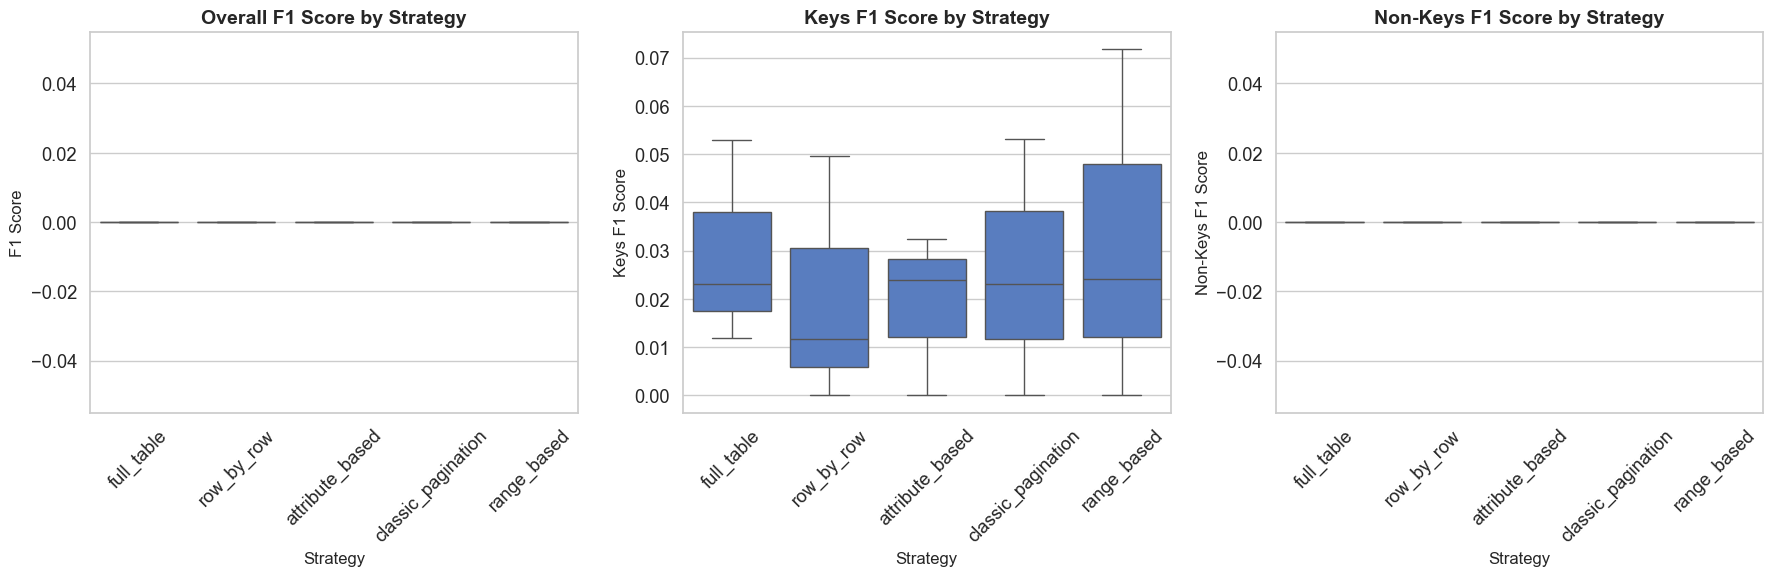

In [58]:
# Plot F1 Score by Strategy
if len(df_results) == 0:
    print("⚠ Cannot plot: No results available")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Overall F1
    sns.boxplot(data=df_results, x='strategy', y='f1_score', ax=axes[0])
    axes[0].set_title('Overall F1 Score by Strategy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Strategy', fontsize=12)
    axes[0].set_ylabel('F1 Score', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)

    # Keys F1
    sns.boxplot(data=df_results, x='strategy', y='keys_f1', ax=axes[1])
    axes[1].set_title('Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Strategy', fontsize=12)
    axes[1].set_ylabel('Keys F1 Score', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)

    # Non-Keys F1
    sns.boxplot(data=df_results, x='strategy', y='non_keys_f1', ax=axes[2])
    axes[2].set_title('Non-Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Strategy', fontsize=12)
    axes[2].set_ylabel('Non-Keys F1 Score', fontsize=12)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(output_dir / 'accuracy_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

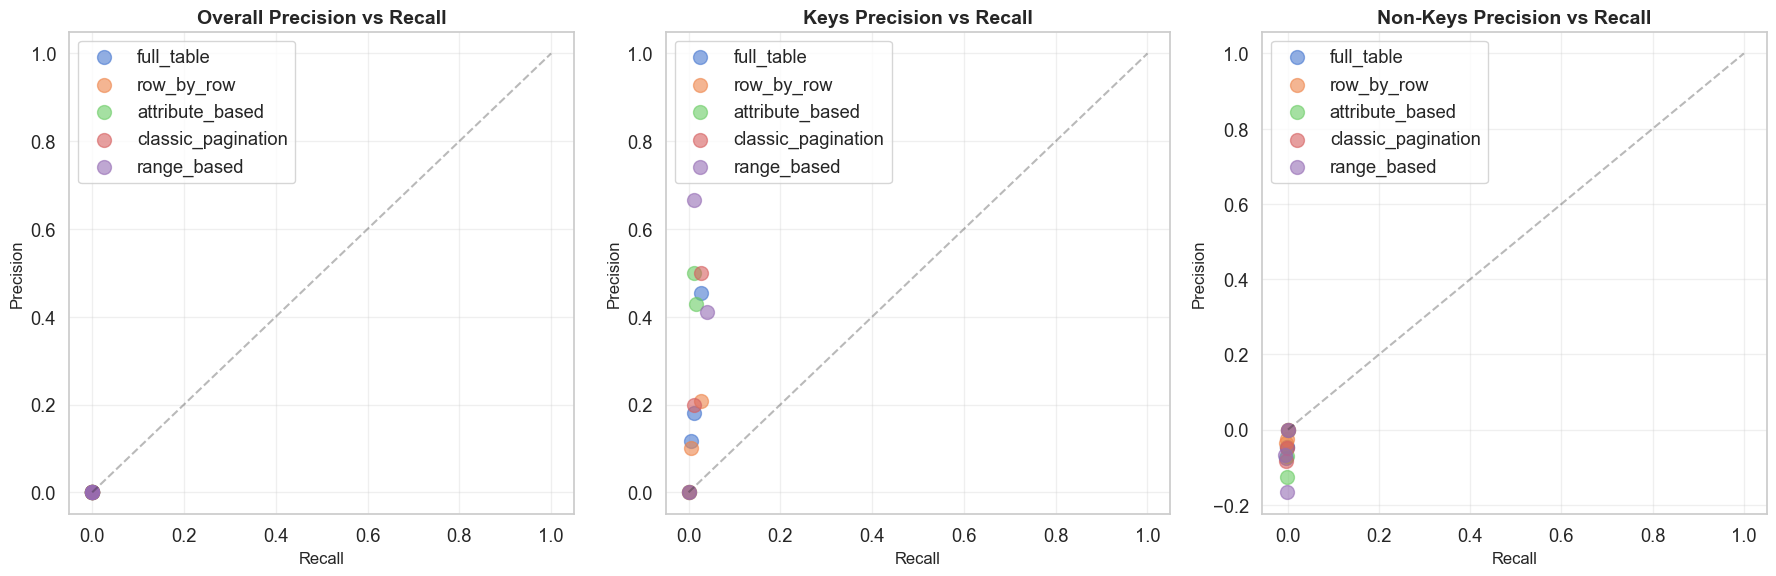

In [59]:
# Precision vs Recall by Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric, title) in enumerate([('Overall', 'Overall'), ('keys', 'Keys'), ('non_keys', 'Non-Keys')]):
    recall_col = f'{metric}_recall' if metric != 'Overall' else 'recall'
    precision_col = f'{metric}_precision' if metric != 'Overall' else 'precision'
    
    for strategy in df_results['strategy'].unique():
        strategy_data = df_results[df_results['strategy'] == strategy]
        axes[idx].scatter(strategy_data[recall_col], strategy_data[precision_col], 
                         label=strategy, alpha=0.6, s=100)
    
    axes[idx].set_title(f'{title} Precision vs Recall', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Recall', fontsize=12)
    axes[idx].set_ylabel('Precision', fontsize=12)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 2: Performance Analysis

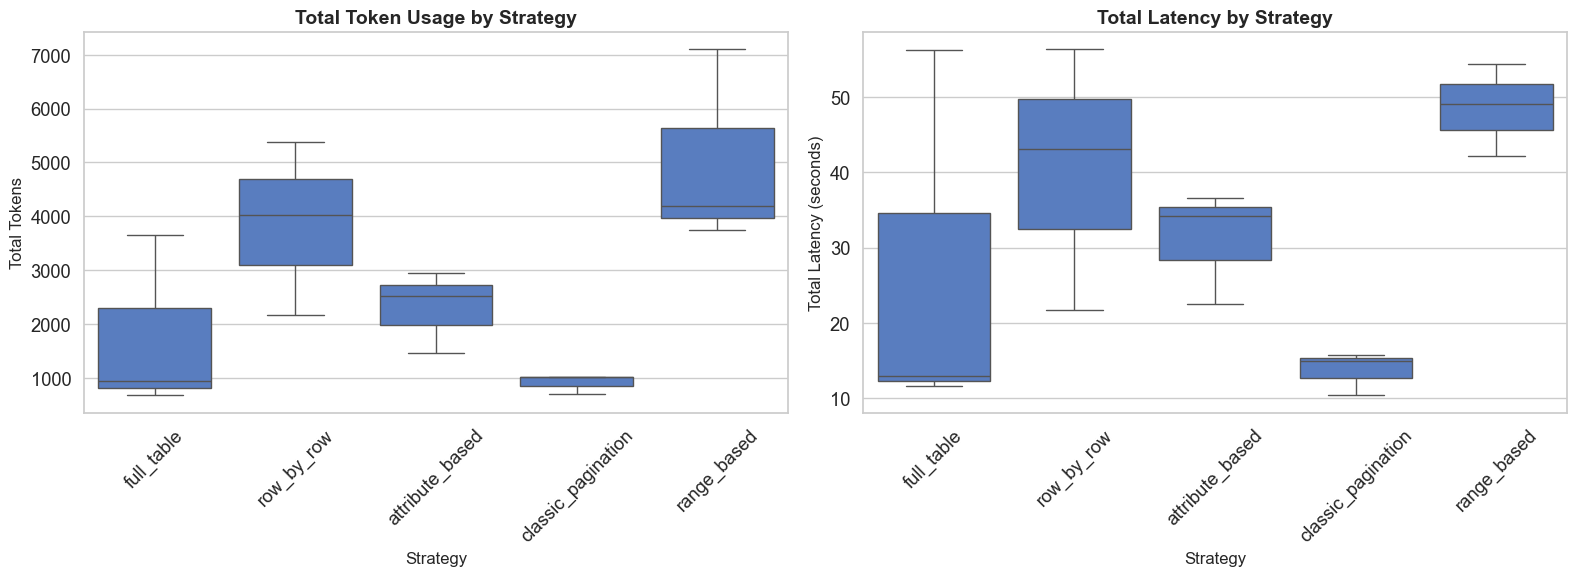

In [60]:
# Token Usage and Latency by Strategy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Token usage
sns.boxplot(data=df_results, x='strategy', y='total_tokens', ax=axes[0])
axes[0].set_title('Total Token Usage by Strategy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Total Tokens', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Latency
sns.boxplot(data=df_results, x='strategy', y='total_latency', ax=axes[1])
axes[1].set_title('Total Latency by Strategy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Total Latency (seconds)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'performance_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Efficiency Metrics

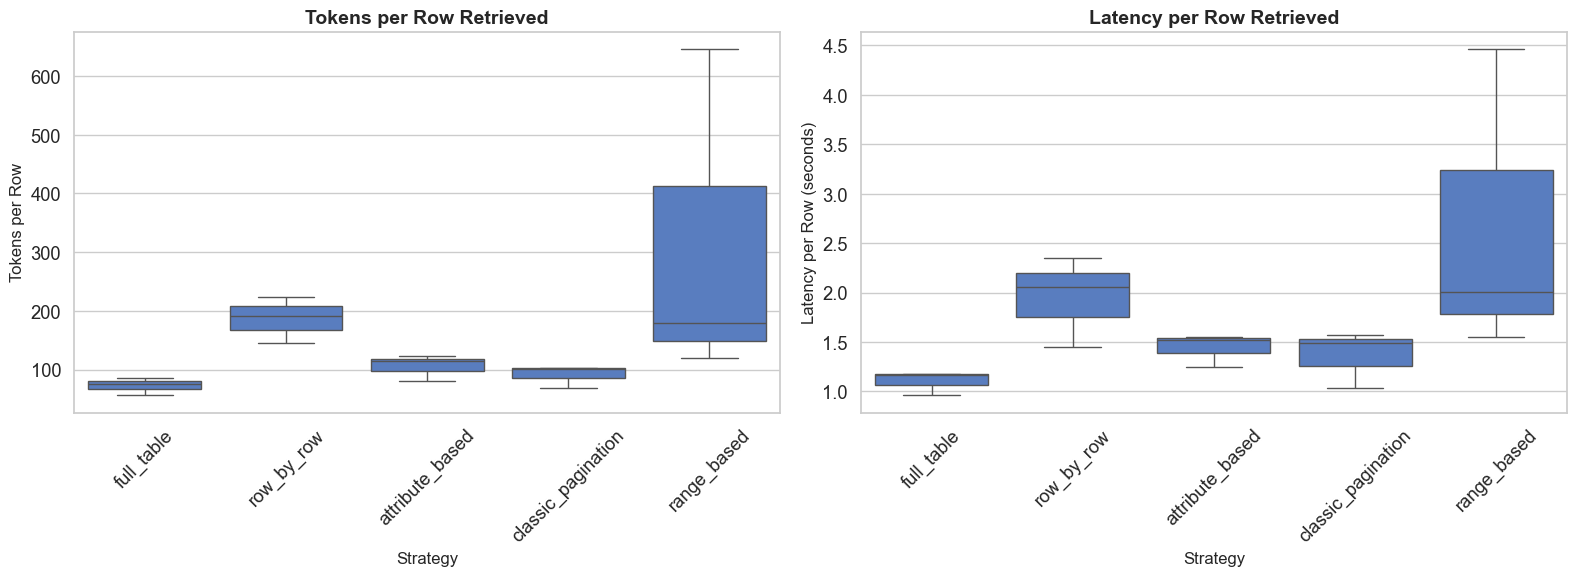

In [61]:
# Efficiency: Tokens and Latency per Row
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Tokens per row
sns.boxplot(data=df_results, x='strategy', y='tokens_per_row', ax=axes[0])
axes[0].set_title('Tokens per Row Retrieved', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Tokens per Row', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Latency per row
sns.boxplot(data=df_results, x='strategy', y='latency_per_row', ax=axes[1])
axes[1].set_title('Latency per Row Retrieved', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Latency per Row (seconds)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'efficiency_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

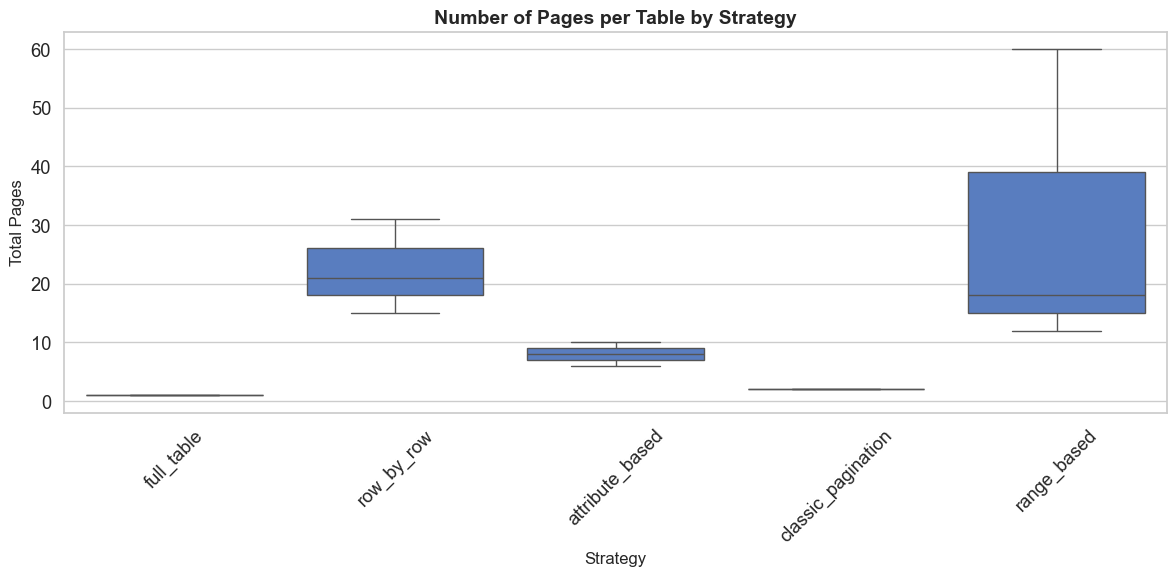

In [62]:
# Pages per Table by Strategy
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='strategy', y='total_pages')
plt.title('Number of Pages per Table by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Pages', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'pages_per_table.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 4: Quality Metrics

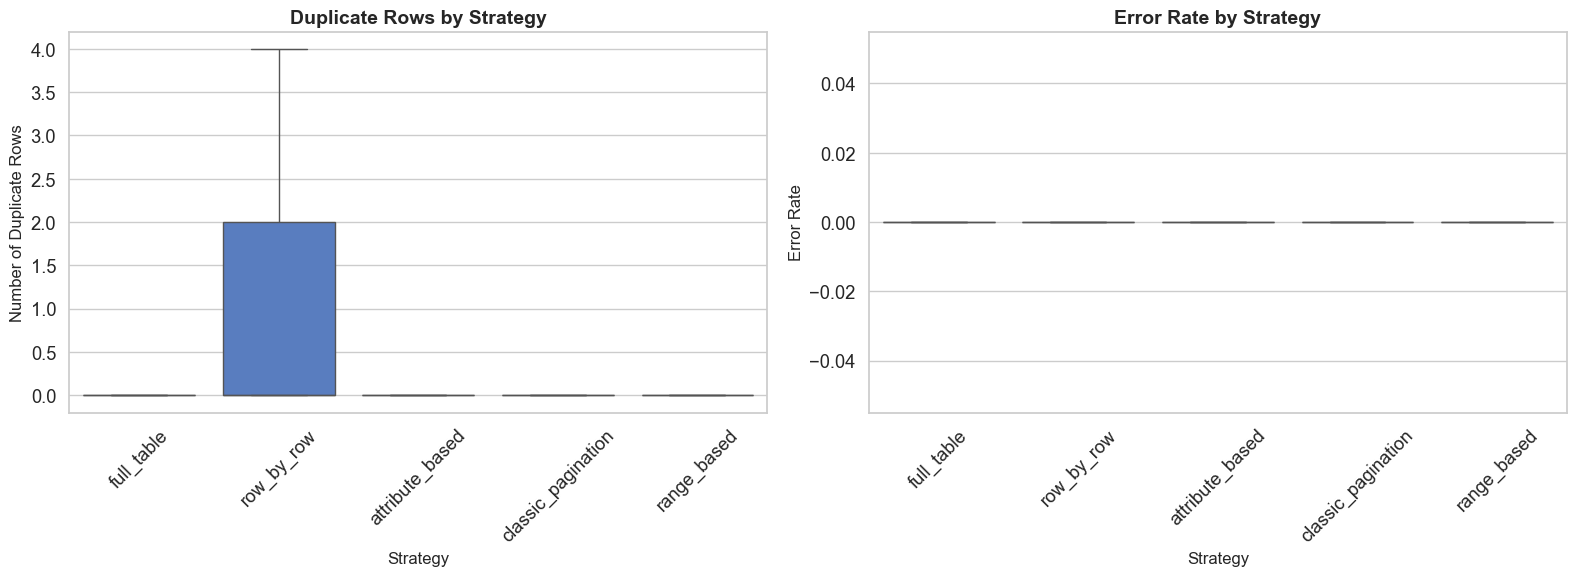

In [63]:
# Quality Metrics: Duplicates and Error Rate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Duplicate rows
sns.boxplot(data=df_results, x='strategy', y='duplicate_rows', ax=axes[0])
axes[0].set_title('Duplicate Rows by Strategy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Number of Duplicate Rows', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Error rate
sns.boxplot(data=df_results, x='strategy', y='error_rate', ax=axes[1])
axes[1].set_title('Error Rate by Strategy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

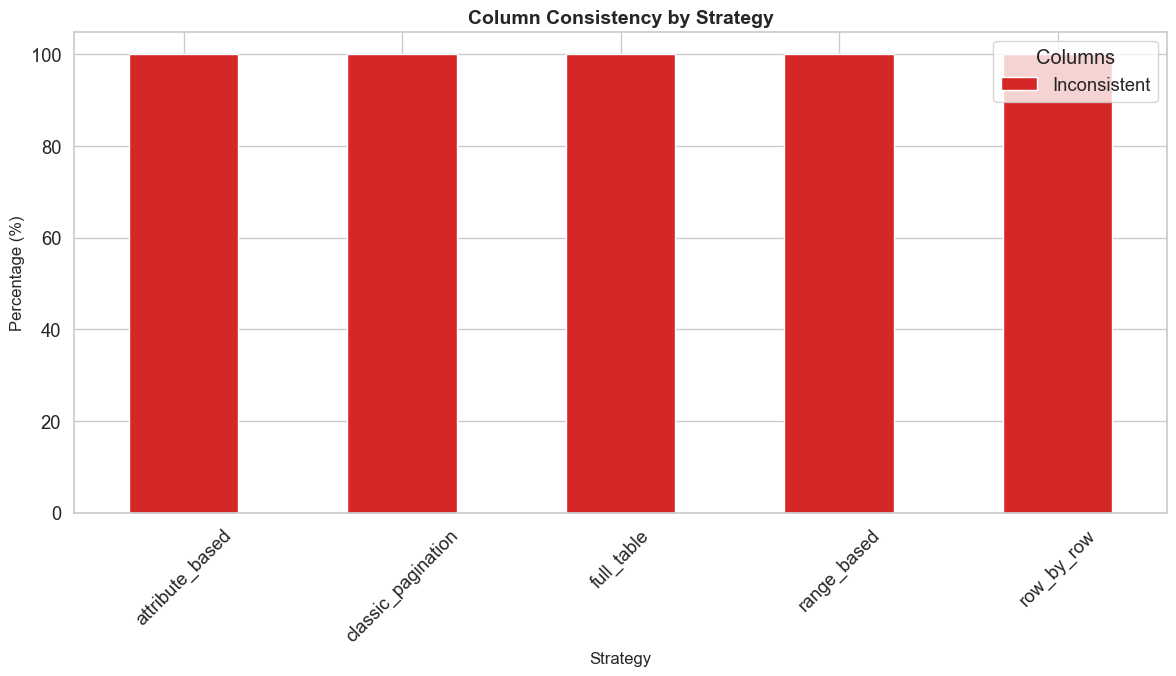

In [64]:
# Column Consistency
consistency_counts = df_results.groupby('strategy')['columns_consistent'].value_counts().unstack(fill_value=0)
consistency_pct = consistency_counts.div(consistency_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
consistency_pct.plot(kind='bar', stacked=True, color=['#d62728', '#2ca02c'])
plt.title('Column Consistency by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(['Inconsistent', 'Consistent'], title='Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'column_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Trade-off Analysis

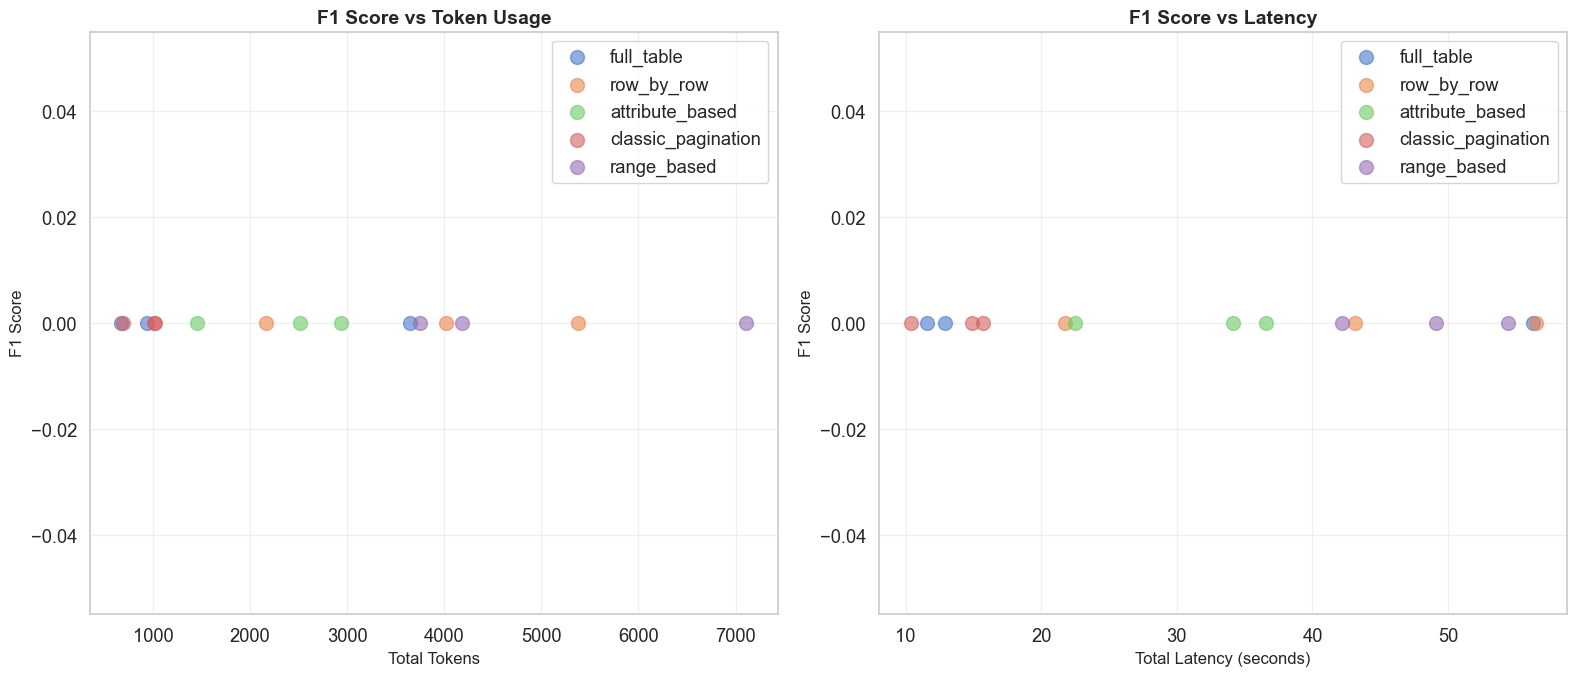

In [65]:
# F1 Score vs Token Usage
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Tokens
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['total_tokens'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Token Usage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Tokens', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Latency
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['total_latency'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Latency', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Latency (seconds)', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'tradeoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

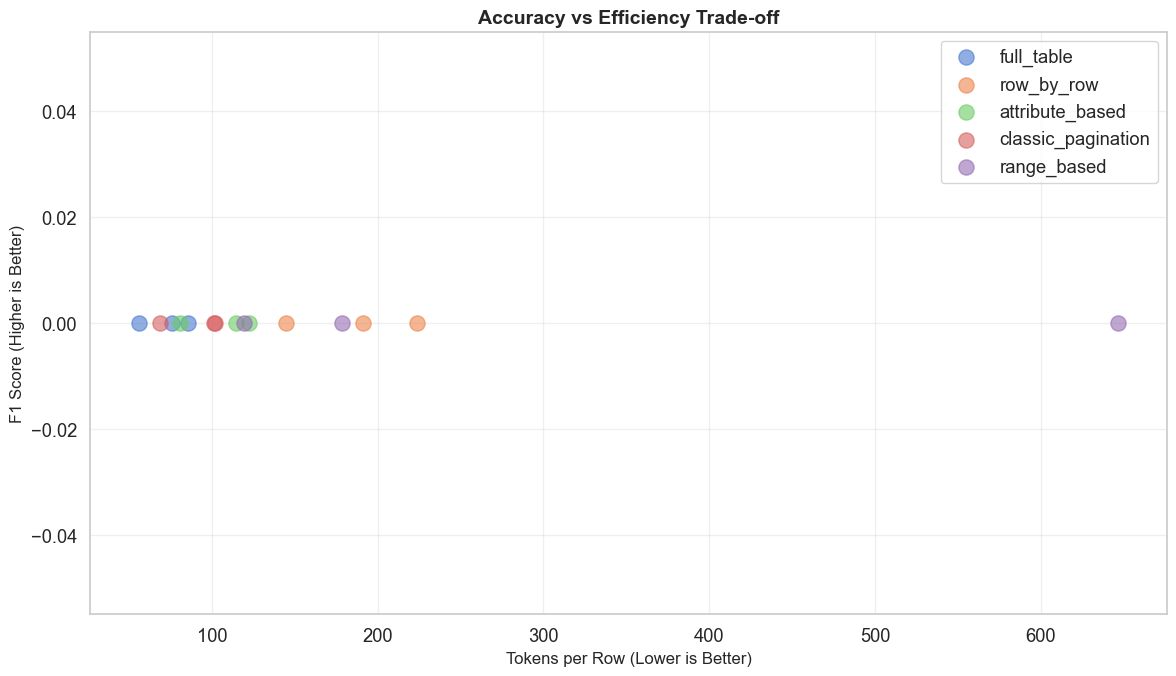

In [66]:
# Pareto Frontier: F1 vs Efficiency (Tokens per Row)
plt.figure(figsize=(12, 7))

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    plt.scatter(strategy_data['tokens_per_row'], strategy_data['f1_score'], 
               label=strategy, alpha=0.6, s=120)

plt.title('Accuracy vs Efficiency Trade-off', fontsize=14, fontweight='bold')
plt.xlabel('Tokens per Row (Lower is Better)', fontsize=12)
plt.ylabel('F1 Score (Higher is Better)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'pareto_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Table Characteristics Analysis

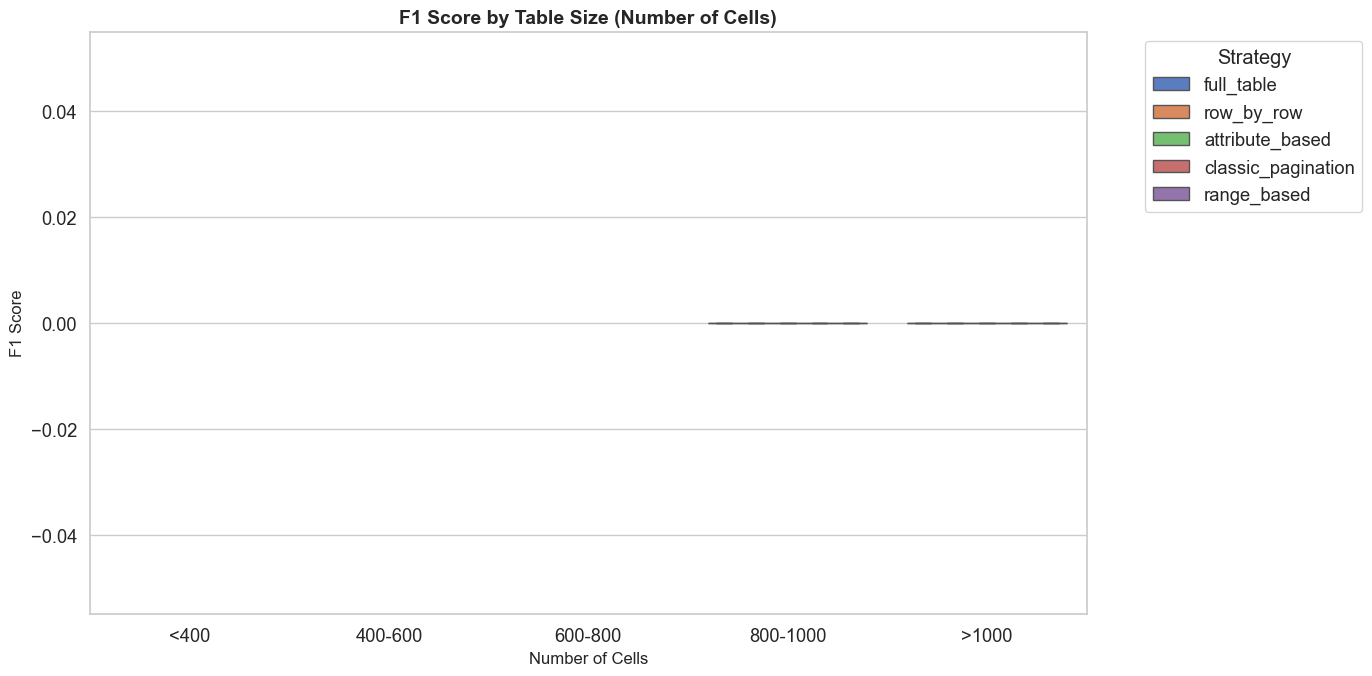

In [67]:
# F1 Score by Table Size (Number of Cells)
# Bin tables by cell count
df_results['cell_bin'] = pd.cut(df_results['num_cells'], 
                                 bins=[0, 400, 600, 800, 1000, float('inf')],
                                 labels=['<400', '400-600', '600-800', '800-1000', '>1000'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='cell_bin', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Size (Number of Cells)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Cells', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_size.png', dpi=300, bbox_inches='tight')
plt.show()

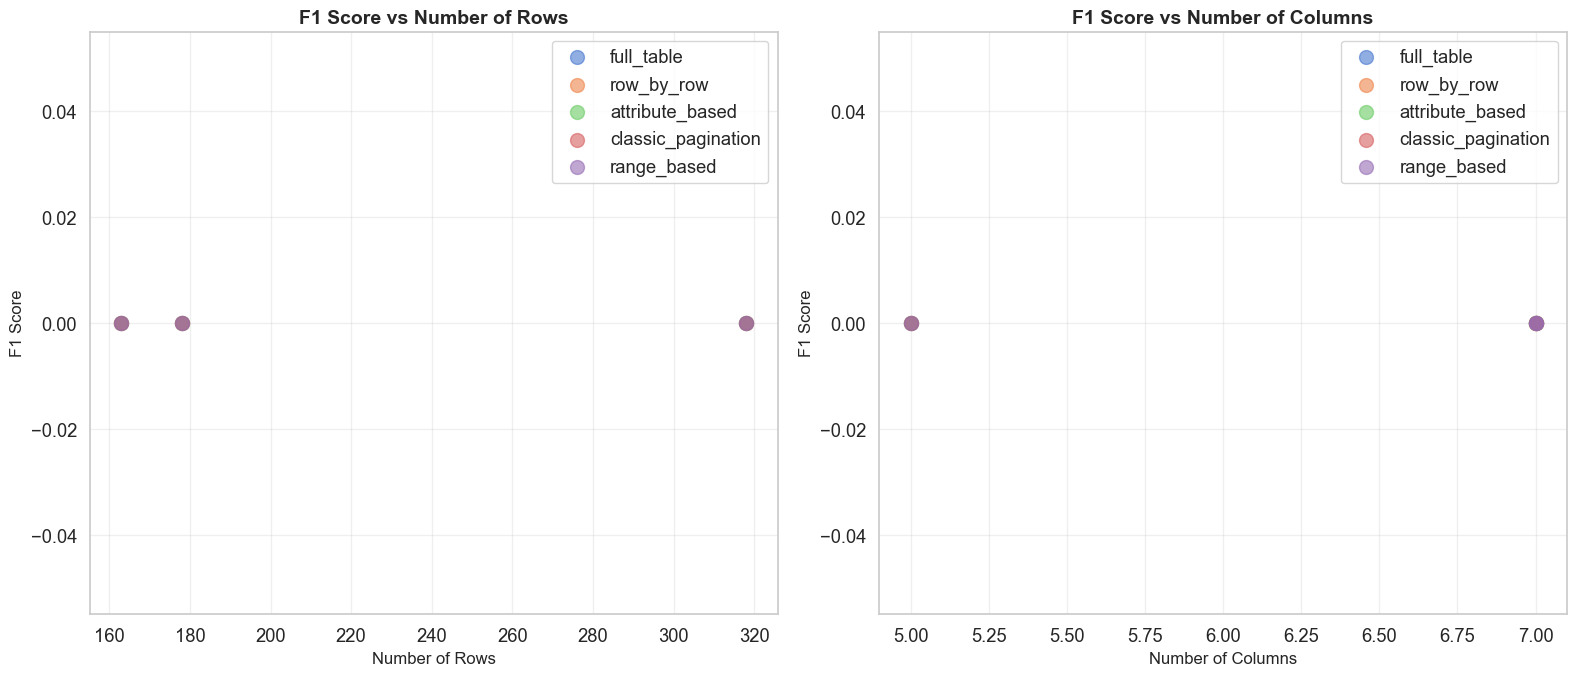

In [68]:
# F1 Score vs Number of Rows and Columns
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Number of Rows
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['num_rows'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Number of Rows', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Rows', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Number of Columns
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['num_cols'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Number of Columns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Columns', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'f1_by_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

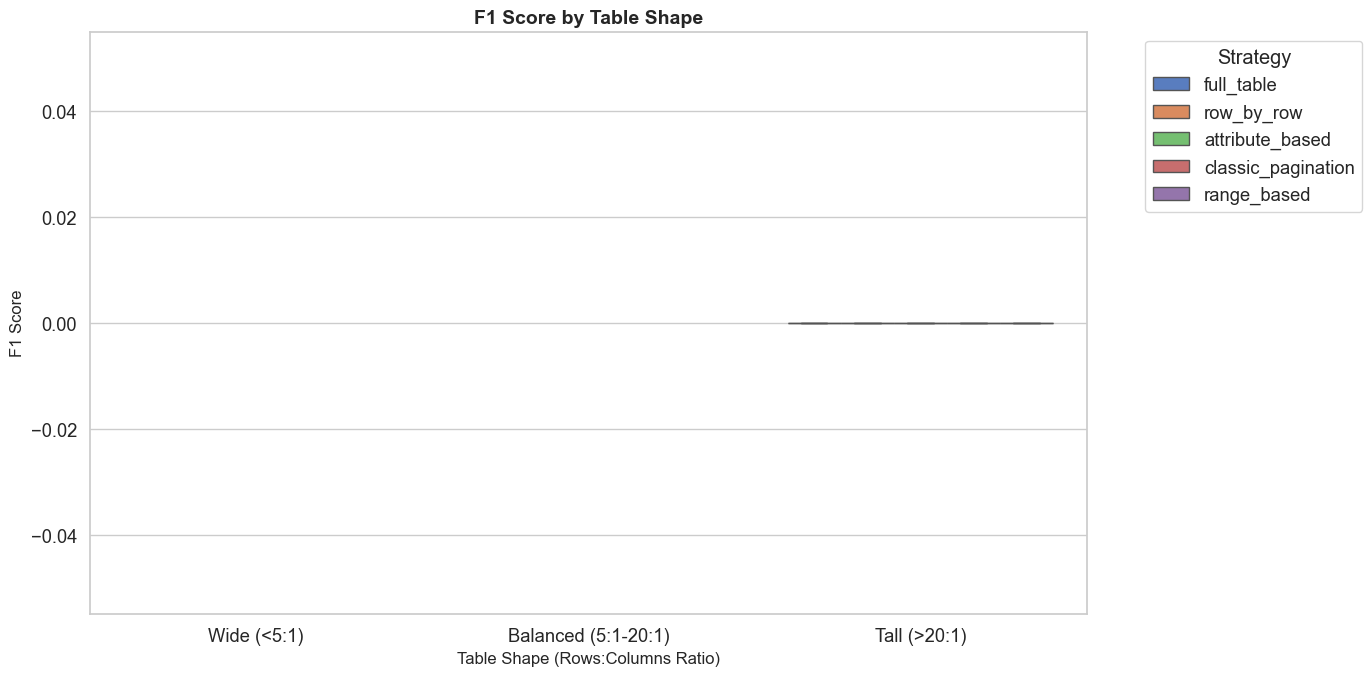

In [69]:
# Table Shape Analysis: Performance on Tall vs Wide Tables
df_results['aspect_ratio'] = df_results['num_rows'] / df_results['num_cols']
df_results['table_shape'] = pd.cut(df_results['aspect_ratio'], 
                                    bins=[0, 5, 20, float('inf')],
                                    labels=['Wide (<5:1)', 'Balanced (5:1-20:1)', 'Tall (>20:1)'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='table_shape', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Shape', fontsize=14, fontweight='bold')
plt.xlabel('Table Shape (Rows:Columns Ratio)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_shape.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Summary Report

In [70]:
# Generate comprehensive summary report
print("="*70)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)
print(f"\nDataset: {len(df_results['table_id'].unique())} tables")
print(f"Strategies: {len(df_results['strategy'].unique())}")
print(f"Total evaluations: {len(df_results)}")

print("\n" + "="*70)
print("OVERALL PERFORMANCE BY STRATEGY")
print("="*70)

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    
    print(f"\n{strategy.upper()}:")
    print(f"  F1 Score:        {strategy_data['f1_score'].mean():.4f} ± {strategy_data['f1_score'].std():.4f}")
    print(f"  Keys F1:         {strategy_data['keys_f1'].mean():.4f} ± {strategy_data['keys_f1'].std():.4f}")
    print(f"  Non-Keys F1:     {strategy_data['non_keys_f1'].mean():.4f} ± {strategy_data['non_keys_f1'].std():.4f}")
    print(f"  Avg Tokens:      {strategy_data['total_tokens'].mean():.0f}")
    print(f"  Avg Latency:     {strategy_data['total_latency'].mean():.2f}s")
    print(f"  Tokens/Row:      {strategy_data['tokens_per_row'].mean():.2f}")
    print(f"  Latency/Row:     {strategy_data['latency_per_row'].mean():.3f}s")
    print(f"  Avg Pages:       {strategy_data['total_pages'].mean():.1f}")
    print(f"  Duplicate Rate:  {strategy_data['duplicate_rows'].mean():.2f}")
    print(f"  Error Rate:      {strategy_data['error_rate'].mean():.4f}")

print("\n" + "="*70)
print("BEST PERFORMING STRATEGIES")
print("="*70)

best_f1 = df_results.groupby('strategy')['f1_score'].mean().idxmax()
best_efficiency = df_results.groupby('strategy')['tokens_per_row'].mean().idxmin()
best_speed = df_results.groupby('strategy')['latency_per_row'].mean().idxmin()

print(f"\nHighest F1 Score:     {best_f1}")
print(f"Most Token Efficient: {best_efficiency}")
print(f"Fastest:              {best_speed}")

print("\n" + "="*70)
print(f"All results saved to: {output_dir}")
print("="*70)

COMPREHENSIVE EVALUATION SUMMARY

Dataset: 3 tables
Strategies: 5
Total evaluations: 15

OVERALL PERFORMANCE BY STRATEGY

FULL_TABLE:
  F1 Score:        0.0000 ± 0.0000
  Keys F1:         0.0293 ± 0.0212
  Non-Keys F1:     0.0000 ± 0.0000
  Avg Tokens:      1754
  Avg Latency:     26.90s
  Tokens/Row:      72.59
  Latency/Row:     1.103s
  Avg Pages:       1.0
  Duplicate Rate:  0.00
  Error Rate:      0.0000

ROW_BY_ROW:
  F1 Score:        0.0000 ± 0.0000
  Keys F1:         0.0204 ± 0.0259
  Non-Keys F1:     0.0000 ± 0.0000
  Avg Tokens:      3853
  Avg Latency:     40.44s
  Tokens/Row:      186.58
  Latency/Row:     1.952s
  Avg Pages:       22.3
  Duplicate Rate:  1.33
  Error Rate:      0.0000

ATTRIBUTE_BASED:
  F1 Score:        0.0000 ± 0.0000
  Keys F1:         0.0188 ± 0.0168
  Non-Keys F1:     0.0000 ± 0.0000
  Avg Tokens:      2303
  Avg Latency:     31.07s
  Tokens/Row:      105.86
  Latency/Row:     1.442s
  Avg Pages:       8.0
  Duplicate Rate:  0.00
  Error Rate:      0.

In [71]:
# Save final summary statistics
final_summary = {
    'timestamp': timestamp,
    'num_tables': len(df_results['table_id'].unique()),
    'num_strategies': len(df_results['strategy'].unique()),
    'total_evaluations': len(df_results),
    'strategy_performance': {},
    'best_strategies': {
        'highest_f1': best_f1,
        'most_efficient': best_efficiency,
        'fastest': best_speed
    }
}

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    final_summary['strategy_performance'][strategy] = {
        'f1_score_mean': float(strategy_data['f1_score'].mean()),
        'f1_score_std': float(strategy_data['f1_score'].std()),
        'keys_f1_mean': float(strategy_data['keys_f1'].mean()),
        'non_keys_f1_mean': float(strategy_data['non_keys_f1'].mean()),
        'avg_tokens': float(strategy_data['total_tokens'].mean()),
        'avg_latency': float(strategy_data['total_latency'].mean()),
        'tokens_per_row': float(strategy_data['tokens_per_row'].mean()),
        'latency_per_row': float(strategy_data['latency_per_row'].mean())
    }

summary_json_file = output_dir / 'final_summary.json'
with open(summary_json_file, 'w', encoding='utf-8') as f:
    json.dump(final_summary, f, indent=2)

print(f'Saved final summary to {summary_json_file}')

Saved final summary to processing/3_metrics/20251004_231045/final_summary.json
